<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Definitions (no ambiguity)
- Throughout: $h_i^{(l)}$ = the feature vector of node $i$ at layer $l$.  
  It is computed from the previous layer's node features $h_j^{(l-1)}$.

---

## What we start with
- A graph (nodes + edges).  
- Feature matrix:
$$X \in \mathbb{R}^{n\times d},\qquad X_i = \text{row } i \text{ (node } i\text{)}.$$

**Example (n=3, d=2):**
$$X = \begin{bmatrix} 1.0 & 0.5 \\[4pt] 0.2 & 0.1 \\[4pt] 0.7 & 0.8 \end{bmatrix} \quad\text{(A=[1.0,0.5], B=[0.2,0.1], C=[0.7,0.8])}$$

---

## Vanilla neural layer (baseline)
- Formula:
$$H^{(1)} = \sigma(XW)$$
- Meaning: apply the same linear map $W$ and nonlinearity $\sigma$ to each node **independently**.  
- Limitation: each $h_i^{(1)}$ depends only on $h_i^{(0)}$ (no edges).

**Concrete example:**  
A's new vector $h_A^{(1)} = \sigma([1.0,0.5]W)$. Neighbors B,C have zero influence.

---

## Inject graph structure (adjacency)
- Adjacency matrix $A$ with $A_{ij}=1$ if $i$ connected to $j$.  
- Naive graph version:
$$H^{(1)} = \sigma(AXW)$$
- Effect: each row of $AX$ is the **sum of neighbors' feature rows** (nodes "look at" neighbors).  
- Limitation: node's own feature is excluded.

**Concrete example:** if A connected to B and C,
$$(AX)_A = X_B + X_C.$$

---

## Add self-loops (include self)
- Define $\tilde{A} = A + I$. Now each node aggregates itself + neighbors:
$$\tilde{A}X \quad\text{gives rows } (X_i + \sum_{j\in N(i)} X_j).$$

---

## Degree imbalance problem & normalization intuition
- Summing causes high-degree nodes to have large-magnitude vectors; low-degree nodes remain small → unstable, biased training.
- Degree matrix after adding self-loops:
$$\tilde{D}_{ii} = \sum_j \tilde{A}_{ij}.$$
- Row-average idea: divide each node by its degree ($\tilde{D}^{-1}\tilde{A}$).  
- Preferred symmetric normalization (GCN standard):
$$\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}$$
This preserves symmetry and yields stable training.

---

## GCN propagation rule (compact, KaTeX-ready)
$$\boxed{\;H^{(l)} = \sigma\!\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2} \, H^{(l-1)} W\big)\;}$$
Equivalently for node $i$:
$$h_i^{(l)} = \sigma\!\Big(\sum_{j\in N(i)\cup\{i\}} \frac{1}{\sqrt{\deg(i)\deg(j)}} \, W h_j^{(l-1)}\Big).$$

**Intuition (message passing):** gather neighbor + self messages, average fairly, apply learned transform $W$, then $\sigma$.

---

## GCN Mini numerical example (chain A–B–C)
Graph: chain $A\!-\!B\!-\!C$.

Adjacency:
$$A= \begin{bmatrix} 0&1&0\\[4pt] 1&0&1\\[4pt] 0&1&0 \end{bmatrix},\quad \tilde{A}=A+I= \begin{bmatrix} 1&1&0\\[4pt] 1&1&1\\[4pt] 0&1&1 \end{bmatrix}.$$

Degrees:
$$\tilde{D}=\mathrm{diag}(2,3,2).$$

Symmetric normalization:
$$\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2} = \begin{bmatrix} \frac{1}{2} & \frac{1}{\sqrt{6}} & 0\\[6pt] \frac{1}{\sqrt{6}} & \frac{1}{3} & \frac{1}{\sqrt{6}}\\[6pt] 0 & \frac{1}{\sqrt{6}} & \frac{1}{2} \end{bmatrix}.$$

Multiply this matrix by $X$ to get the normalized (self+neigh) averages per node, then apply $W$ and $\sigma$ to produce the next-layer features.

---

## Problems with GCN weighting (motivation for attention)
- GCN weights edges by $1/\sqrt{\deg(i)\deg(j)}$: degree-only dependent.  
- Consequences:
  - All neighbors treated uniformly (after normalization).
  - Useless neighbors can still be weighted highly by degree.
  - Oversmoothing across many layers (features become similar).
  - No feature-adaptive per-edge weighting.

---

## GAT (Graph Attention Network) — core idea
- Replace fixed degree-based weights with learned, feature-dependent attention weights $\alpha_{ij}$.  
- Raw compatibility (unnormalized) for edge $(i,j)$:
$$e_{ij} = a^\top \big[\,W h_i^{(l-1)} \, \Vert \, W h_j^{(l-1)}\,\big]$$
where $a$ is a learnable vector and $\Vert$ denotes concatenation.  
- Normalize across $i$'s neighbors with softmax:
$$\alpha_{ij} = \mathrm{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k\in N(i)} \exp(e_{ik})}.$$
- Update:
$$h_i^{(l)} = \sigma\!\Big(\sum_{j\in N(i)} \alpha_{ij}\, W h_j^{(l-1)}\Big).$$

**Advantage:** weights depend on features; nodes can emphasize relevant neighbors and avoid uniform oversmoothing.

---

## What $e_{ij}$ represents (plain)
- $e_{ij}$ is the raw (unnormalized) attention score: a scalar measuring how informative $j$ is for $i$ given their transformed features.  
- The vector $a$ learns which feature interactions to reward or penalize. Softmax turns raw scores into normalized attention weights $\alpha_{ij}$.

---

## Worked numeric GAT example (step-by-step)
Setup (toy numbers):

Previous-layer features (3D):
$$h_i^{(l-1)}=[1.0,\,0.5,\,-1.0],\quad h_j^{(l-1)}=[0.0,\,2.0,\,1.0],\quad h_k^{(l-1)}=[0.5,\,-1.0,\,0.0].$$

Linear map $W\in\mathbb{R}^{2\times 3}$:
$$W= \begin{bmatrix} 1 & 0 & -1\\[4pt] 0 & 1 &  1 \end{bmatrix}.$$

Attention vector $a\in\mathbb{R}^4$:
$$a=[0.5,\,-0.5,\,0.2,\,0.1]^\top.$$

Step 1 — transformed features:
$$Wh_i=[2.0,\,-0.5],\quad Wh_j=[-1.0,\,3.0],\quad Wh_k=[0.5,\,-1.0].$$

Step 2 — concatenated pairs:
$$[Wh_i\Vert Wh_j]=[2.0,\,-0.5,\,-1.0,\,3.0],\quad [Wh_i\Vert Wh_k]=[2.0,\,-0.5,\,0.5,\,-1.0].$$

Step 3 — raw scores (dot with $a$):
$$e_{ij}=1.35,\qquad e_{ik}=1.25$$
(as computed from the dot-products in the concatenation).

Step 4 — softmax normalization:
$$\alpha_{ij}\approx 0.525,\qquad \alpha_{ik}\approx 0.475.$$

Step 5 — aggregate and activate:
$$\tilde{h}_i = 0.525\cdot Wh_j + 0.475\cdot Wh_k = [-0.2875,\,1.100].$$
Apply ReLU:
$$h_i^{(l)} = \mathrm{ReLU}(\tilde{h}_i) = [0.0,\,1.100].$$

**Interpretation:** neighbor $j$ slightly more relevant; second feature dimension dominates the aggregated signal; ReLU zeros negative first coordinate.

---

## Final integrated checklist (slide-style)
- $h_i^{(l)}$ = node $i$'s feature vector at layer $l$.  
- Vanilla: $\;H^{(l)}=\sigma(H^{(l-1)}W)\;$ — ignores graph.  
- Adjacency: $\;H^{(l)}=\sigma(A H^{(l-1)} W)\;$ — uses neighbors but not self.  
- Self-loops: $\tilde{A}=A+I$ — include self.  
- Normalize: $\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}$ — fair, symmetric averaging.  
- GCN layer: $\;H^{(l)}=\sigma(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2} H^{(l-1)} W)\;$.  
- GAT layer: $\;h_i^{(l)}=\sigma\!\big(\sum_{j}\alpha_{ij} W h_j^{(l-1)}\big)\;$ with $\alpha_{ij}$ derived from $e_{ij}=a^\top[Wh_i\Vert Wh_j]$.

---

<center><img src="GNN_bootcamp-main/images/GAT1.png" width=600></center>
<center><small>image from https://epichka.com/blog/2023/gat-paper-explained/</small></center>

<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

---

## ✅ Shape of W in a Graph Attention Network

In GAT, every layer $\ell$ has a trainable linear projection:
$$z_i^{(\ell)} = W^{(\ell)}\,h_i^{(\ell-1)}.$$

### ✔ If the input node features have dimension:
$$F_{\text{in}}$$

### ✔ And the GAT head outputs features of dimension:
$$F_{\text{out}}$$

### Then the learnable weight matrix is:
$$W \in \mathbb{R}^{F_{\text{out}}\times F_{\text{in}}}.$$

---

## 🔵 Typical shapes (example)

If a GAT layer converts:
- Input feature dimension $=1433$ (CORA)
- Output feature dimension per head $=8$
- Number of heads $=8$

Then each head has
$$W^{(\text{head})}\in\mathbb{R}^{8\times 1433},$$
and the 8 heads produce $8\times 8=64$ output features (then concatenated or averaged depending on the layer).

---

## 🔶 Why this shape?

GAT proceeds as:

1. **Linear projection**
$$z_i = W h_i,\qquad z_j = W h_j$$
2. **Attention score**
$$e_{ij} = a^\top [\,z_i \Vert z_j\,]$$
3. **Softmax over neighbors**
$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k\in N(i)}\exp(e_{ik})}$$
4. **Weighted aggregation**
$$h_i^{\text{new}} = \sigma\!\Big(\sum_{j\in N(i)} \alpha_{ij}\, z_j\Big)$$

Because $z_i\in\mathbb{R}^{F_{\text{out}}}$, $W$ must map $\mathbb{R}^{F_{\text{in}}}\to\mathbb{R}^{F_{\text{out}}}$.

---

## 🟢 Shape of other parameters

- Concatenated pair:
$$[\,z_i\Vert z_j\,]\in\mathbb{R}^{2F_{\text{out}}}.$$
- Attention vector:
$$a\in\mathbb{R}^{2F_{\text{out}}}\quad(\text{or }1\times 2F_{\text{out}}).$$

---

## 📌 Summary (table)

| Quantity                      | Shape                                |
| ----------------------------- | ------------------------------------ |
| Input feature dim             | $F_{\text{in}}$                    |
| Output feature dim per head   | $F_{\text{out}}$                   |
| Weight matrix $W$           | $\mathbb{R}^{F_{\text{out}}\times F_{\text{in}}}$ |
| Attention vector $a$        | $\mathbb{R}^{2F_{\text{out}}}$     |
| Concatenated multi-head output| $H\cdot F_{\text{out}}$            |

---

If you want, I can also provide a small ASCII or SVG diagram showing the flow of shapes through one head.
</div>







In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## GAT in python using Geometric library

The following code demonstrates how to implement a Graph Attention Network (GAT) using PyTorch Geometric with the Cora dataset. It involves defining a GAT model with two graph attention layers, setting up the dataset and data masks, and training the model over a specified number of epochs. The training loop includes computing predictions, calculating the loss, performing backpropagation, and evaluating the model's accuracy on the training and test sets.

In [3]:
from torch_geometric.datasets import Planetoid
import torch_geometric
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
from torch_geometric.transforms import NormalizeFeatures

# Load the Cora dataset
dataset = Planetoid(root=".", name="Cora",transform=NormalizeFeatures())
data = dataset[0]

# Extract training, validation, and test masks from the data
# These masks are boolean arrays indicating which nodes are used for training, validation, and testing
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

# Define the GCN (Graph Convolutional Network) model
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8):
        super().__init__()
        # Define the first graph convolution layer
        self.gat1 = GATv2Conv(in_dim, hidden_dim, heads=8, dropout=0.6)
        # Define the second graph convolution layer
        self.gat2 = GATv2Conv(hidden_dim*heads, out_dim, heads=1, concat=False, dropout=0.6)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        # Apply the first GAT and eLU activation
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        # Apply the second GAT layer
        h = self.gat2(h, edge_index)
        return h 

# Instantiate the GAT model
gat = GAT(dataset.num_features, 32, dataset.num_classes)

# Define the optimizer (Adam) and the loss function (Cross Entropy Loss)
optimizer = optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Set the number of training epochs
n_epochs = 200

# Define a function to calculate accuracy
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

# Training loop
for epoch in range(n_epochs):
    gat.train()
    # Forward pass: Compute predictions
    prediction = gat(data.x, data.edge_index)
    
    # Compute the loss on the training data
    loss = loss_fn(prediction[train_mask, :], data.y[train_mask])
    optimizer.zero_grad()
    # Zero the gradients, perform backpropagation, and update the weights
    loss.backward()
    optimizer.step()
    

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        # Evaluate on the test set without updating weights
        with torch.no_grad():
            gat.eval()
            prediction = gat(data.x, data.edge_index)
            # Calculate training accuracy
            train_acc = accuracy(torch.argmax(prediction[train_mask, :], dim=1), data.y[train_mask])
            test_acc = accuracy(torch.argmax(prediction[test_mask, :], dim=1), data.y[test_mask])
            print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')


Epoch: 0, Loss: 1.9491, Train Accuracy: 0.1429, Test Accuracy: 0.1300
Epoch: 10, Loss: 1.8200, Train Accuracy: 0.7857, Test Accuracy: 0.5630
Epoch: 20, Loss: 1.6426, Train Accuracy: 0.9643, Test Accuracy: 0.8180
Epoch: 30, Loss: 1.3211, Train Accuracy: 0.9357, Test Accuracy: 0.7950
Epoch: 40, Loss: 1.1837, Train Accuracy: 0.9571, Test Accuracy: 0.7880
Epoch: 50, Loss: 0.9807, Train Accuracy: 0.9786, Test Accuracy: 0.8050
Epoch: 60, Loss: 0.9647, Train Accuracy: 0.9857, Test Accuracy: 0.7970
Epoch: 70, Loss: 0.9772, Train Accuracy: 0.9643, Test Accuracy: 0.7720
Epoch: 80, Loss: 0.9236, Train Accuracy: 0.9857, Test Accuracy: 0.8030
Epoch: 90, Loss: 0.7721, Train Accuracy: 0.9929, Test Accuracy: 0.8220
Epoch: 100, Loss: 0.8115, Train Accuracy: 0.9857, Test Accuracy: 0.8090
Epoch: 110, Loss: 0.7849, Train Accuracy: 0.9857, Test Accuracy: 0.8060
Epoch: 120, Loss: 0.7653, Train Accuracy: 0.9929, Test Accuracy: 0.8110
Epoch: 130, Loss: 0.6458, Train Accuracy: 0.9929, Test Accuracy: 0.8090
Epo

<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## Why GCN / GAT do not scale

1. **Full-batch training.**  
   GCN/GAT compute
   $$H^{(l)}=\sigma\big(A\,H^{(l-1)}W\big)$$
   which requires loading the full adjacency and feature matrices and propagating for all nodes every step. For very large graphs (e.g., 100M nodes, 1B edges) this is infeasible: adjacency and feature matrices won't fit in GPU memory and full propagation is prohibitively expensive.

---

## Key insight behind GraphSAGE

To compute a node v's embedding at depth K you only need v's K-hop neighborhood. GCN/GAT waste work by computing embeddings for all nodes. GraphSAGE builds small computation graphs per batch:
- pick a batch of target nodes,
- fetch their 1-hop neighbors, then 2-hop neighbors, … up to K hops,
- compute embeddings only on that subgraph,
enabling mini-batch training similar to CNNs/Transformers.

---

## The K‑hop explosion problem

Average-degree d example:
- 1-hop ≈ d
- 2-hop ≈ d^2
- 3-hop ≈ d^3  
With d≈30: 1-hop=30, 2-hop=900, 3-hop=27k. Hubs (nodes with huge degree) make this worse. Uncontrolled K‑hop expansion breaks mini-batching.

---

## GraphSAGE's solution: fixed-size neighbor sampling

Fix per-layer sample sizes, e.g. sample_size = [10, 10] for 2 layers:
- For one target node: sample 10 neighbors (1-hop).
- For each sampled neighbor, sample 10 neighbors (2-hop).
Total nodes ≈ 1 + 10 + 100 = 111 instead of thousands/millions. This bounds computation and memory.

---

## GraphSAGE layer: what happens

For each layer k and node v:
- Collect sampled neighbor set N(v) (including v if you use self-loop aggregation).
- Aggregate neighbor features with an aggregator (mean, LSTM, pooling).
- Combine aggregated neighbor representation with v's own representation, then apply linear transform and nonlinearity.

Mean-aggregation formula (KaTeX-ready):
$$h_v^{(k)}=\sigma\!\Big(W^{(k)}\;\mathrm{MEAN}\big(\{h_v^{(k-1)}\}\cup\{h_u^{(k-1)}:u\in N(v)\}\big)\Big).$$

Notes:
- MEAN(...) averages v and its sampled neighbors.
- $W^{(k)}$ maps input→output features for layer k.
- $\sigma$ is an elementwise activation (e.g., ReLU).

---

## GraphSAGE aggregators (intuition)

1. **Mean aggregator** — average neighbor vectors (simple, fast, stable).
   $$h_v^{(k)} = W^{(k)}\big(\mathrm{mean}(\{h_v^{(k-1)}\}\cup\{h_u^{(k-1)}\})\big)$$
2. **LSTM aggregator** — run an LSTM over a (randomly-ordered) neighbor sequence; expressive but expensive.
3. **Pooling aggregator** — apply a small MLP to each neighbor then elementwise max (captures strong signals).

---

## Why GraphSAGE generalizes inductively

GraphSAGE learns a mapping from (node features, sampled neighbor features) → embedding. It does not rely on a stored embedding for every node or on the full adjacency during inference, so it can embed unseen nodes and nodes in new graphs (inductive capability).

---

## How mini-batching works (conceptual)

- Choose batch of target nodes.
- For each target, sample fixed-size neighbors per layer to form a small computation subgraph (a tree-like structure).
- Send only that subgraph (nodes + edges + features) to GPU.
- Compute forward/backward on that mini-subgraph and update parameters.
Full graph stays on CPU/disk; GPU holds only the current mini-subgraph.

---

## What is aggregated and how

- Aggregated items: neighbor feature vectors (optionally including the target node once as self).
- Aggregation functions: mean / sum / LSTM pooling / MLP+max, etc.
- After aggregation, combine (concatenate or apply linear map) with target node's own vector, then apply nonlinearity.

---

## The computation graph (visual/structural picture)

- For target nodes and K layers, the computation graph is the K‑hop sampled subgraph (a small directed acyclic graph from input features at layer 0 up to outputs at layer K).  
- Each GNN layer consumes the previous-layer features of nodes in this subgraph, runs aggregation for each target-node's local neighborhood (sampled), and produces next-layer features only for nodes in the subgraph.

---

## Why sampling is needed

- To bound memory and compute: uncontrolled neighborhood expansion makes per-batch computation huge.
- To enable stochastic optimization: sampling yields small, varied mini-batches enabling SGD-style updates.
- To make training feasible on very large graphs and to control workload per GPU.


c:\ProgramData\anaconda3\envs\pyg-clean\lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data_dict[key] = torch.as_tensor(value)


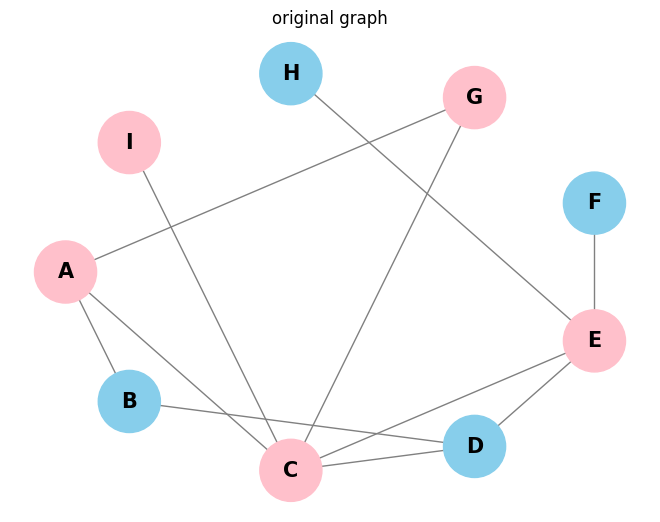

Subgraph 0 input nodes: ['A', 'C']
Subgraph 0 all nodes: ['A', 'C', 'G', 'E', 'H']
Subgraph 0 nodes: ['A', 'C', 'G', 'E', 'H']
Subgraph 0 edges: [('C', 'A'), ('G', 'A'), ('E', 'C'), ('A', 'C'), ('A', 'G'), ('C', 'G'), ('C', 'E'), ('H', 'E')]
Subgraph 1 input nodes: ['E', 'G']
Subgraph 1 all nodes: ['E', 'G', 'F', 'C', 'A', 'D', 'B']
Subgraph 1 nodes: ['E', 'G', 'F', 'C', 'A', 'D', 'B']
Subgraph 1 edges: [('F', 'E'), ('C', 'E'), ('A', 'G'), ('C', 'G'), ('E', 'F'), ('A', 'C'), ('D', 'C'), ('B', 'A'), ('G', 'A')]
Subgraph 2 input nodes: ['I']
Subgraph 2 all nodes: ['I', 'C', 'G', 'D']
Subgraph 2 nodes: ['I', 'C', 'G', 'D']
Subgraph 2 edges: [('C', 'I'), ('G', 'C'), ('D', 'C')]


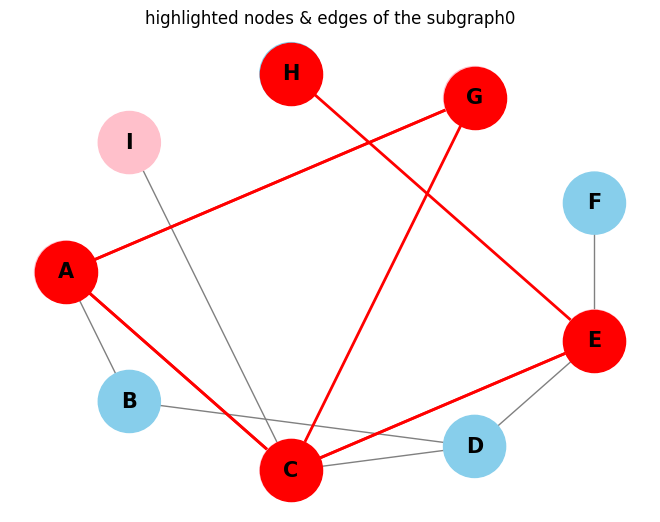

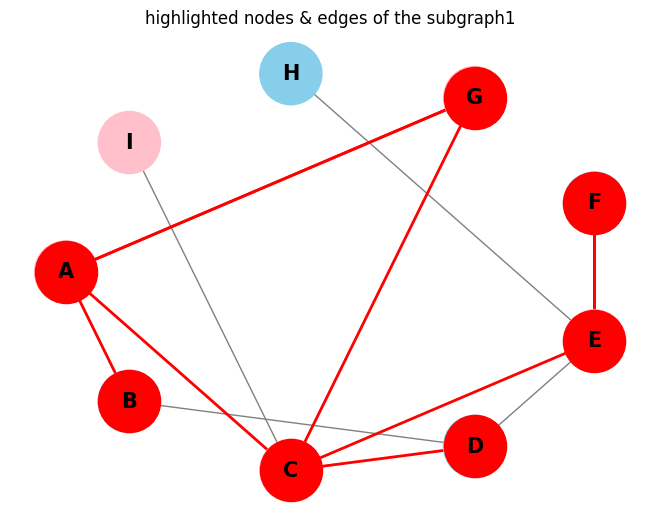

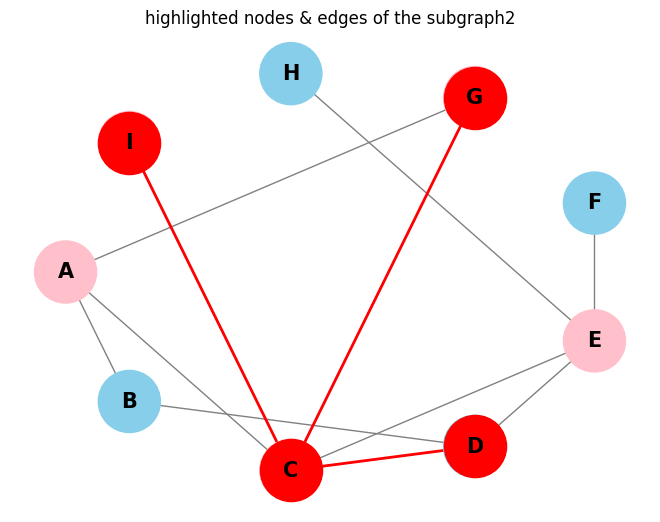

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import NeighborLoader

# Define the graph structure
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E'), ('E', 'F'), ('G', 'A'), ('G', 'C'), ('H', 'E'), ('I', 'C')]

# Create a NetworkX undirected graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Assign random features, labels, and train_mask to nodes
features = {node: np.random.rand(3) for node in nodes}
labels = {node: np.random.randint(2) for node in nodes}
train_mask = {node: idx % 2 == 0 for idx, node in enumerate(nodes)}

# Add attributes to the graph
nx.set_node_attributes(G, features, 'x')
nx.set_node_attributes(G, labels, 'y')
nx.set_node_attributes(G, train_mask, 'train_mask')

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)

train_loader = NeighborLoader(
    data,
    num_neighbors=[2, 2],
    batch_size=2,
    input_nodes=data.train_mask,
    shuffle=False
)

# Function to visualize a graph
def visualize_graph(G, subgraph_edges=None, subgraph_nodes=None):
    fig = plt.figure()
    pos = nx.shell_layout(G)
    train_mask_color = ['pink' if G.nodes[node]['train_mask'] else 'skyblue' for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=train_mask_color, font_size=15, font_weight='bold', edge_color='gray')

    if subgraph_edges:
        nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, edge_color='red', width=2)
    if subgraph_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=subgraph_nodes, node_color='red', node_size=2000)

# Visualize the main graph
visualize_graph(G)
plt.title('original graph')
plt.show()
# Visualize subgraphs from the DataLoader
node_mapping = {i: node for i, node in enumerate(nodes)}

for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i} input nodes: {[node_mapping[node.item()] for node in subgraph.input_id]}')
    print(f'Subgraph {i} all nodes: {[node_mapping[node.item()] for node in subgraph.n_id]}')

    # Convert subgraph edge_index to original graph edges
    subgraph_edge_index = subgraph.edge_index.numpy()
    subgraph_edges = [(node_mapping[subgraph_edge_index[0, j]], node_mapping[subgraph_edge_index[1, j]]) for j in range(subgraph_edge_index.shape[1])]

    # Correctly map edges using n_id
    original_indices = subgraph.n_id.tolist()
    reverse_mapping = {idx: node_mapping[node] for idx, node in enumerate(original_indices)}
    subgraph_edges = [(reverse_mapping[src], reverse_mapping[dst]) for src, dst in zip(subgraph_edge_index[0], subgraph_edge_index[1])]

    # Convert subgraph node indices to original graph node names
    subgraph_nodes = [node_mapping[node.item()] for node in subgraph.n_id]

    print(f'Subgraph {i} nodes: {subgraph_nodes}')
    print(f'Subgraph {i} edges: {subgraph_edges}')
    
    # Visualize the subgraph on the original graph
    visualize_graph(G, subgraph_edges=subgraph_edges, subgraph_nodes=subgraph_nodes)
    plt.title(f'highlighted nodes & edges of the subgraph{i}')


### Interpreting the Subgraph Output

Each printed block describes **one extracted subgraph** from the original graph.

**1. Input nodes:**  
These are the **starting nodes** used to grow the subgraph (seed nodes).

**2. All nodes:**  
All nodes reachable from the input nodes **within the extraction rule** (e.g., k-hop neighborhood, BFS, induced edges).  
This represents the *full set of nodes* included in the subgraph.

**3. Nodes:**  
Same as “all nodes” — the actual node list used when constructing the subgraph object.

**4. Edges:**  
All edges from the original graph **whose endpoints are both inside the node list**.  
This is the *induced edge set*.

**In summary:**  
A subgraph = (seed input nodes) + (all reachable nodes) + (all edges between them).


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## GraphSAGE and inductive learning

GraphSAGE is designed for **inductive learning**: it learns a mapping (an aggregation function + transform) that can produce embeddings for nodes unseen during training. This is essential for dynamic graphs where new nodes arrive after model training.

### How it works (conceptual)
- During training, GraphSAGE learns per-layer functions that map:
  (node features, sampled neighbor features) → node embedding.
- The learned functions do not store per-node parameters; they operate on features and sampled neighborhoods.
- At inference time for a new node v:
  - Collect v's neighbors' features (sample if needed).
  - Apply the same learned layer-wise aggregation + transforms to compute v's embedding.

### Why this enables inductive generalization
- The model has learned *how to aggregate* neighbor information, not an embedding table keyed by node id.
- Therefore the model can be applied to any node with features and neighbors (including nodes in new graphs).

### Visual (figure caption)
<center><img src="GNN_bootcamp-main/images/inductive_learning.png" width="500"></center>  
<center><small>image from https://wandb.ai/syllogismos/machine-learning-with-graphs/reports/8-Graph-Neural-Networks--VmlldzozNzcwMTA</small></center>

### Short summary
- GraphSAGE trains an inductive aggregator + transform.
- New nodes → gather neighbors → apply learned aggregator → compute embedding.
- Works for streaming or growing graphs without retraining embeddings for the whole graph.

</div>


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## GraphSAGE in industry — PinSage and large-scale recommendation

GraphSAGE is widely used in industry because it scales to large graphs via neighbor sampling and inductive aggregation. Recommender systems at scale (Pinterest, Uber Eats) adapt GraphSAGE ideas; PinSage is a notable example that replaces fixed-size uniform sampling with a random-walk–based neighborhood selection to find more relevant neighbors.

---

## PinSage: random-walk neighborhood selection (intuition)

For each item node $u$:
1. Simulate multiple short random walks starting from $u$.
2. Count visits to other nodes across those walks.
3. Normalize visit counts to get a relevance score per node.
4. Select the top $T$ nodes by normalized visit frequency as $u$'s neighborhood (instead of choosing a fixed-size uniform sample).

This yields a neighborhood that emphasizes nodes frequently encountered by random walks from $u$ — i.e., nodes that are structurally and semantically more relevant to $u$.

---

## Why PinSage improves on vanilla GraphSAGE for recommendations

- **Adaptive relevance:** Random walks highlight nodes that are structurally/behaviorally close to $u$, not just uniformly sampled neighbors.  
- **Better signal for retrieval:** High-visit nodes are more likely to be useful candidates for recommendations.  
- **Scalability:** Walk-based precomputation (or online sampling) yields a compact, focused neighborhood (top‑T) that still bounds computation like GraphSAGE sampling.  
- **Empirical benefits:** In practice, PinSage shows better retrieval/recall for item-to-item recommendations on very large graphs.

---

## Practical notes

- Random-walk counts can be computed offline (preprocessing) or sampled online; trade-offs exist between freshness and compute.  
- The top‑T selection compresses a potentially huge neighborhood into a manageable, high-quality candidate set for aggregation.  
- After neighborhood selection, aggregation and embedding computation follow the usual GraphSAGE pipeline (mean/pooling/LSTM, linear transform, activation).

---

## Summary

- GraphSAGE provides scalable, inductive embedding via fixed-size sampling and aggregation.  
- PinSage replaces uniform sampling with random-walk–based neighbor ranking, selecting the top‑T most-visited nodes per item.  
- The result is a focused, relevant neighborhood that improves recommendation quality while retaining computational scalability.

</div>


<div style="background:#f7f7f7; padding:20px; border-radius:12px; line-height:1.5;">

## PPI dataset — minimal reference (KaTeX-ready)

### What it is
- **PPI = Protein–Protein Interaction dataset** used for GNN research.  
- A collection of graphs; **each graph = a tissue/sample**.  
- **Nodes:** proteins.  
- **Edges:** physical interactions between proteins.  
- **Task:** node-level, multi-label classification (predict biological functions).

---

### Key properties (simple)
- Total graphs: **24** (20 train / 2 val / 2 test).  
- Graph scale: **thousands of nodes per graph** (large graphs).  
- Node features: ~**50** dimensions (biological attributes).  
- Node labels: **121** possible labels (multi-label per node).

---

### Intuition
Predict a protein's biological roles from its feature vector and the features of interacting proteins (its graph neighborhood).

---

### If needed
I can also provide:
- exact tensor shapes (features, labels, edge_index),
- a small PyG loading example,
- or a schema diagram.

</div>


In [5]:
from torch_geometric.datasets import PPI  # Import the PPI dataset class
from torch_geometric.data import Batch  # Import the Batch class for grouping graphs
from torch_geometric.loader import NeighborLoader  # Import NeighborLoader for sampling neighbors
from torch_geometric.loader import DataLoader  # Import DataLoader for batching graphs
from torch_geometric.nn import GraphSAGE  # Import the GraphSAGE model
from sklearn.metrics import f1_score  # Import f1_score for evaluating classification performance
import torch

# Load PPI dataset splits for training, validation, and testing
train_dataset = PPI(root="./data", split='train') #20 graphs
val_dataset = PPI(root="./data", split='val') #2 graphs
test_dataset = PPI(root="./data", split='test') #2 graphs

# Combine all training graphs into a single graph for sampling
train_data = Batch.from_data_list(train_dataset)

# Create a NeighborLoader for sampling neighbors in link prediction tasks
loader = NeighborLoader(train_data, batch_size=2048,
                        shuffle=True, num_neighbors=[20, 10],
                        num_workers=2, persistent_workers=True)

# Create DataLoaders for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Determine the device for training (CUDA if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the GraphSAGE model with specific parameters
model = GraphSAGE(
    in_channels=train_dataset.num_features,  # Number of input features, here 50
    hidden_channels=512,                    # Number of hidden units
    num_layers=2,                           # Number of GraphSAGE layers
    out_channels=train_dataset.num_classes,  # Number of output classes, here 121
).to(device)  # Move the model to the appropriate device

# Define the loss function (Binary Cross Entropy with logits). The problem is multi-label classification, hence binary cross entropy is used for each label analysis.
criterion = torch.nn.BCEWithLogitsLoss()
# Define the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(301):
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss for this epoch

    # Iterate over batches in the training set
    for data in train_loader:
        data = data.to(device)  # Move data to the appropriate device
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass through the model
        out = model(data.x, data.edge_index)
        
        # Compute loss
        loss = criterion(out, data.y) # no need to use masking here because the data is already separated to train, val and test.
        total_loss += loss.item() * data.num_graphs  # Accumulate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Validation step
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        data = next(iter(val_loader))  # Get the only batch from the loader (reminder: val_dataset only had 2 graphs and the batch size is set to 2)
        out = model(data.x.to(device), data.edge_index.to(device))  # Forward pass
        preds = (out > 0).float().cpu()  # Apply threshold to get predictions
        y, pred = data.y.numpy(), preds.numpy()  # Convert to numpy arrays
        # Compute F1 score
        val_f1 = f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

    # Compute average loss for the epoch
    total_loss = total_loss / len(train_loader.dataset)
    
    # Print training loss and validation F1 score every 50 epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.3f} | Val F1 score: {val_f1:.4f}')

# Final evaluation on the test set
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    data = next(iter(test_loader))  # Get the only batch from the test loader
    out = model(data.x.to(device), data.edge_index.to(device))  # Forward pass
    preds = (out > 0).float().cpu()  # Apply threshold to get predictions
    y, pred = data.y.numpy(), preds.numpy()  # Convert to numpy arrays
    # Compute F1 score for the test set
    test_f1 = f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

# Print the final test F1 score
print(f'Test F1 score: {test_f1:.4f}')


Epoch   0 | Train Loss: 0.589 | Val F1 score: 0.3999
Epoch  50 | Train Loss: 0.190 | Val F1 score: 0.8400
Epoch 100 | Train Loss: 0.142 | Val F1 score: 0.8772
Epoch 150 | Train Loss: 0.121 | Val F1 score: 0.8938
Epoch 200 | Train Loss: 0.119 | Val F1 score: 0.9000
Epoch 250 | Train Loss: 0.097 | Val F1 score: 0.9091
Epoch 300 | Train Loss: 0.094 | Val F1 score: 0.9110
Test F1 score: 0.9329


In [17]:
print(G.nodes)
print(G.edges)
print(G.adj)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
[('A', 'B'), ('A', 'C'), ('A', 'G'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('C', 'G'), ('C', 'I'), ('D', 'E'), ('E', 'F'), ('E', 'H')]
{'A': {'B': {}, 'C': {}, 'G': {}}, 'B': {'A': {}, 'D': {}}, 'C': {'A': {}, 'D': {}, 'E': {}, 'G': {}, 'I': {}}, 'D': {'B': {}, 'C': {}, 'E': {}}, 'E': {'C': {}, 'D': {}, 'F': {}, 'H': {}}, 'F': {'E': {}}, 'G': {'A': {}, 'C': {}}, 'H': {'E': {}}, 'I': {'C': {}}}
